# 01 Data Loading and Naive Baseline

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Embedding,
    LSTM,
    Bidirectional,
    Dense,
    Dropout,
    GlobalMaxPooling1D
)
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install mlxtend

In [3]:
TRAIN_FILE_PATH = '/content/drive/MyDrive/hw6/train.csv'
TEST_FILE_PATH  = '/content/drive/MyDrive/hw6/test.csv'

data = pd.read_csv(TRAIN_FILE_PATH)
testdata = pd.read_csv(TEST_FILE_PATH)

X_train = data['Title'] + " " + data['Description']
y_train = data['Class Index'].apply(lambda x: x - 1).values

X_test = testdata['Title'] + " " + testdata['Description']
y_test = testdata['Class Index'].apply(lambda x: x - 1).values

print("Train size:", len(X_train))
print("Test size:", len(X_test))


Train size: 120000
Test size: 7600


In [4]:
def keyword_baseline(text):
    text = text.lower()
    if any(k in text for k in ["stock", "market", "bank", "company", "profit"]):
        return 2  # Business
    if any(k in text for k in ["game", "team", "match", "league", "coach"]):
        return 1  # Sports
    if any(k in text for k in ["technology", "tech", "science", "software", "ai"]):
        return 3  # Sci/Tech
    return 0      # World

baseline_preds = [keyword_baseline(x) for x in X_test]

print("Baseline Accuracy:",
      accuracy_score(y_test, baseline_preds))


Baseline Accuracy: 0.4025


In [5]:
maxlen = 200
vocab_size = 20000

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=maxlen, padding='post', truncating='post')

print("X_train shape:", X_train_pad.shape)
print("X_test shape:", X_test_pad.shape)


X_train shape: (120000, 200)
X_test shape: (7600, 200)


In [6]:
embed_size = 128

model = Sequential([
    Input(shape=(maxlen,)),
    Embedding(vocab_size, embed_size),

    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64, return_sequences=True)),

    GlobalMaxPooling1D(),

    Dense(256, activation='relu'),
    Dropout(0.3),

    Dense(4, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200, 128)       │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,021,572 (11.53 MB)

 Trainable params: 3,021,572 (11.53 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    X_train_pad[:20000],
    y_train[:20000],
    validation_split=0.1,
    epochs=1,
    batch_size=1024,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
    ],
    verbose=1
)


18/18 ━━━━━━━━━━━━━━━━━━━━ 302s 16s/step - accuracy: 0.3357 - loss: 1.3601 - val_accuracy: 0.6685 - val_loss: 0.9484


In [8]:
ai_preds = np.argmax(model.predict(X_test_pad, verbose=0), axis=1)

print("AI Accuracy :", accuracy_score(y_test, ai_preds))
print("AI Precision:", precision_score(y_test, ai_preds, average='micro'))
print("AI Recall   :", recall_score(y_test, ai_preds, average='micro'))
print("AI F1       :", f1_score(y_test, ai_preds, average='micro'))


AI Accuracy : 0.6455263157894737
AI Precision: 0.6455263157894737
AI Recall   : 0.6455263157894737
AI F1       : 0.6455263157894737


In [9]:
results = pd.DataFrame({
    "Method": ["Keyword Baseline", "BiLSTM Pipeline"],
    "Accuracy": [
        accuracy_score(y_test, baseline_preds),
        accuracy_score(y_test, ai_preds)
    ]
})

results


,Method,Accuracy
0,Keyword Baseline,0.402500
1,BiLSTM Pipeline,0.645526


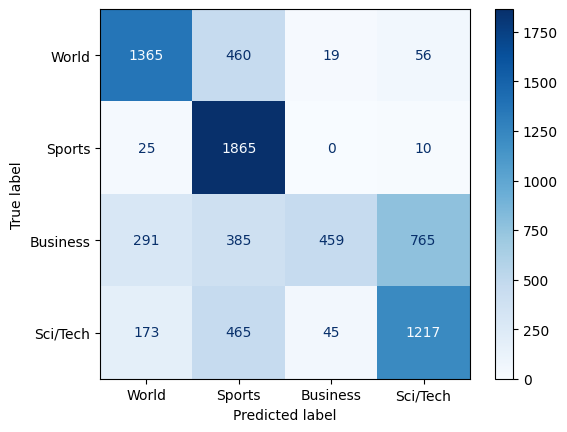

In [10]:
cm = confusion_matrix(y_test, ai_preds)
labels = ['World', 'Sports', 'Business', 'Sci/Tech']

disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()


In [11]:
label_map = ['World', 'Sports', 'Business', 'Sci/Tech']

for i in range(3):
    print("TEXT:", X_test.iloc[i][:120], "...")
    print("GT :", label_map[y_test[i]])
    print("Baseline:", label_map[baseline_preds[i]])
    print("AI:", label_map[ai_preds[i]])
    print("-" * 60)


TEXT: Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks ...
GT : Business
Baseline: World
AI: Sports
------------------------------------------------------------
TEXT: The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A  ...
GT : Sci/Tech
Baseline: Sports
AI: Sci/Tech
------------------------------------------------------------
TEXT: Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of Loui ...
GT : Sci/Tech
Baseline: Business
AI: World
------------------------------------------------------------
